<h3>Шевченко Кристина Евгеньевна</h3>
<h3>https://t.me/kr1588</h3>

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from catboost import Pool, CatBoostClassifier
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import string
import re
import tqdm

nltk.download('stopwords')
stopword_ru = stopwords.words('russian')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
import warnings
warnings.filterwarnings("ignore")


In [5]:
orders = pd.read_feather('/kaggle/input/data-repit/orders.feather')
suit = pd.read_feather('/kaggle/input/data-repit/suitable_teachers.feather')
teach = pd.read_feather('/kaggle/input/data-repit/teachers_info.feather')

In [6]:
teach = teach.loc[teach.rating>0]

In [7]:
class Repetit:
    def __init__(self, data, suit, teach, tt_or_tn, *args):
        """
        На вход подаются 3 датасета,
        tt_or_tn - 'tt' или 'tn' соответственно тестовая или обучающая выборка,
        *args - векторайзеры
        """
        self.data = data
        self.suit = suit
        self.teach = teach
        self.tt_or_tn = tt_or_tn
        self.vectorizer = args
    def transform(self, num_feat=100):
        """
        num_feat - значение max_features в CountVectorizer
        """
        #удаление дубликатов
        self.data.drop_duplicates(inplace=True)
        self.data = self.data.reset_index(drop=True)
        
        #замена в status_id нулями значения, неравные 6 или 13
        self.data['status_id'] = self.data['status_id'].where(self.data['status_id'].isin([6, 13]),
                                                              other=0)
        
        #замена всех дубликатов в status_id на оплачено, если хотя бы один
        #из дубликатов оплачен
        val0 = list(self.data.loc[(self.data.original_order_id.isnull()) & (self.data.status_id.isin([6, 13])),
                      'id'].values)
        self.data.loc[self.data.original_order_id.isin(val0), 'status_id'] = 6
        gr = self.data.groupby(['original_order_id', 
                                'status_id']).agg({'status_id':['max']}).reset_index()
        gr.columns = ['original_order_id', 'status_id', 'st_id']
        val = list(gr.loc[gr.status_id.isin([6, 13])]['original_order_id'].values)
        self.data.loc[self.data.original_order_id.isin(val), 'status_id'] = 1
        self.data.loc[self.data.id.isin(val), 'status_id'] = 1
        self.data.loc[self.data.status_id.isin([6, 13]), 'status_id'] = 1
        
        #получение признака same_price: 1, если цена за урок одинаковы 
        #и у подходящего учителя и у ученика, 0, если не одинаковы
        su_te = self.suit.merge(self.teach[['user_id', 'rating', 'lesson_cost']],
                                how='left',
                                left_on='teacher_id',
                                right_on='user_id')
        tr_su_te = self.data[['id', 'lesson_price']].merge(su_te,
                                                           how='left',
                                                           left_on='id',
                                                           right_on='order_id')[['id', 'teacher_id',
                                                                                 'enable_auto_assign', 'rating',
                                                                                 'lesson_price', 'lesson_cost']]
        tr_su_te['same_price'] = 0
        tr_su_te.loc[tr_su_te.lesson_price==tr_su_te.lesson_cost, 'same_price'] = 1
        
        #признаки mean_enab - среднее по значению enable_auto_assign подходящих
        #для заявки учителей, count_teach - число подходящих учителей,
        #median_rat - медиана рэйтинга подходящих учителей,
        #mean_same_price - среднее значение признака same_price(1-одинаковые 
        #указанные цены у учителя и в заявке, 0-разные) 
        tr_su_te = tr_su_te.groupby('id').agg({'teacher_id':'count',
                                               'enable_auto_assign':'mean',
                                               'rating':'median',
                                               'same_price':'mean'}).reset_index()
        tr_su_te.columns = ['id', 'count_teach', 'mean_enab', 'median_rat', 'mean_same_price']
        self.data = self.data.merge(tr_su_te,
                                    how='left',
                                    left_on='id',
                                    right_on='id')
        
        #заполнение пропусков 
        self.data['mean_enab'] = self.data['mean_enab'].fillna(0)
        self.data['median_rat'] = self.data['median_rat'].fillna('unknown')
        self.data['subject_id'] = self.data['subject_id'].fillna('unknown')
        self.data['lesson_place'] = self.data['lesson_place'].fillna('не указано')
        self.data['pupil_category_new_id'] = self.data['pupil_category_new_id'].fillna('unknown')
        self.data['order_date'] = pd.to_datetime(self.data.order_date)
        self.data['original_order_id'] = self.data['original_order_id'].fillna('unknown')
        
        #удаление признаков
        self.data = self.data.drop(['id', 'order_date', 'start_date', 'home_metro_id',
                                    'working_teacher_id', 'amount_to_pay',
                                    'first_lesson_date', 'minimal_price',
                                    'client_id', 'creator_id', 'additional_status_id',
                                    'max_metro_distance', 'estimated_fee', 'payment_date'], axis=1)
        self.data['purpose'] = self.data['purpose'].fillna('незаполнено')
        self.data['add_info'] = self.data['add_info'].fillna('незаполнено')
        self.data['comments'] = self.data['comments'].fillna('незаполнено')
        
        #преобразование текстовых признаков purpose и add_info с помощью CountVectorizer
        #с учётом характера выборки(обучающая или тестовая)
        if self.vectorizer:
            pur = self.vectorization(self.data, 'purpose', self.tt_or_tn,
                                     num_feat,
                                     vectorizer=self.vectorizer[0])[0]
            add_info = self.vectorization(self.data, 'add_info', self.tt_or_tn,
                                          num_feat,
                                          vectorizer=self.vectorizer[1])[0]
        else:
            pur, vectorizer_pur = self.vectorization(self.data, 'purpose',
                                                     self.tt_or_tn, num_feat)
            add_info, vectorizer_add_info = self.vectorization(self.data, 'add_info',
                                                               self.tt_or_tn, num_feat)
        self.data = pd.concat([self.data, pur, add_info], sort=False, axis=1)
        self.data = self.data.drop(['prefered_teacher_id', 'original_order_id',
                                    'purpose', 'add_info', 'comments'],
                                   axis=1)
            
        #выделение таргета
        df_X = self.data.drop('status_id', axis=1)
        df_Y = self.data['status_id']
        
        #преобразование категориальных признаков в тип str
        cat_features = [0] + list(range(2,8)) + [10, 11] + list(range(14,18)) + [20]
    
        for i in cat_features:
            df_X.iloc[:, i] = df_X.iloc[:, i].astype(str)
        if self.tt_or_tn == 'tt':
            return df_X, df_Y
        return df_X, df_Y, vectorizer_pur, vectorizer_add_info
    
    @staticmethod
    def vectorization(df, name, tt_or_tn, num_feat, vectorizer=None):
        """
        функция преобразования текстового признака
        """
        tokenized = []
        for q in df[name]:
            s = re.sub(r'[^\w\s]', ' ', q)
            s = ' '.join([i for i in  s.split() if i not in stopword_ru])
            tokenized.append(s)
        if tt_or_tn == 'tn':
            vectorizer = CountVectorizer(analyzer = "word",
                                         lowercase = True,
                                         tokenizer = None,
                                         preprocessor = None,
                                         max_features = num_feat)
            bow = vectorizer.fit_transform(tokenized)
        elif tt_or_tn == 'tt':
            bow = vectorizer.transform(tokenized)
        tokens = vectorizer.get_feature_names_out()
        bow_df = pd.DataFrame(data = bow.toarray(),
                              columns = list([i + '_' + name for i in tokens]))
        return bow_df, vectorizer

In [8]:
train, test = train_test_split(orders, test_size=0.3, random_state=42)

In [9]:
train = train.drop(train.loc[train['subject_id'].isin([3.211265e+06, 3.342337e+06, 3.605505e+06])].index)
test = test.drop(test.loc[test['subject_id'].isin([3.211265e+06, 3.342337e+06, 3.605505e+06])].index)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [10]:
#получение обучающей выборки и векторайзеров 
r1 = Repetit(train, suit, teach, 'tn')
train_X, train_Y, vec1, vec2 = r1.transform()

In [11]:
#получение тестовой выборки с помощью полученных до этого векторайзеров
r2 = Repetit(test, suit, teach, 'tt', vec1, vec2)
test_X, test_Y = r2.transform()

<h3>Обучение модели</h3>


In [12]:
cat_features = [0] + list(range(2,8)) + [10, 11] + list(range(14,18)) + [20]

In [13]:
data = Pool(data=train_X, label=train_Y, cat_features=cat_features)

In [15]:
model = CatBoostClassifier(iterations=300, learning_rate=0.2, depth=9)
model.fit(data, verbose=False)

In [16]:
cb_probs = model.predict_proba(test_X)
cb_probs = cb_probs[:, 1]
cb_auc = roc_auc_score(test_Y, cb_probs)
print('Значение ROC-AUC:', cb_auc)

Значение ROC-AUC: 0.7331843203301411


In [17]:
report = classification_report(test_Y, model.predict(test_X), target_names=['0', '1'])

In [18]:
print('Метрики precision и recall', '\n\n', report)

Метрики precision и recall 

               precision    recall  f1-score   support

           0       0.86      0.98      0.92    306369
           1       0.36      0.07      0.11     51100

    accuracy                           0.85    357469
   macro avg       0.61      0.52      0.52    357469
weighted avg       0.79      0.85      0.80    357469



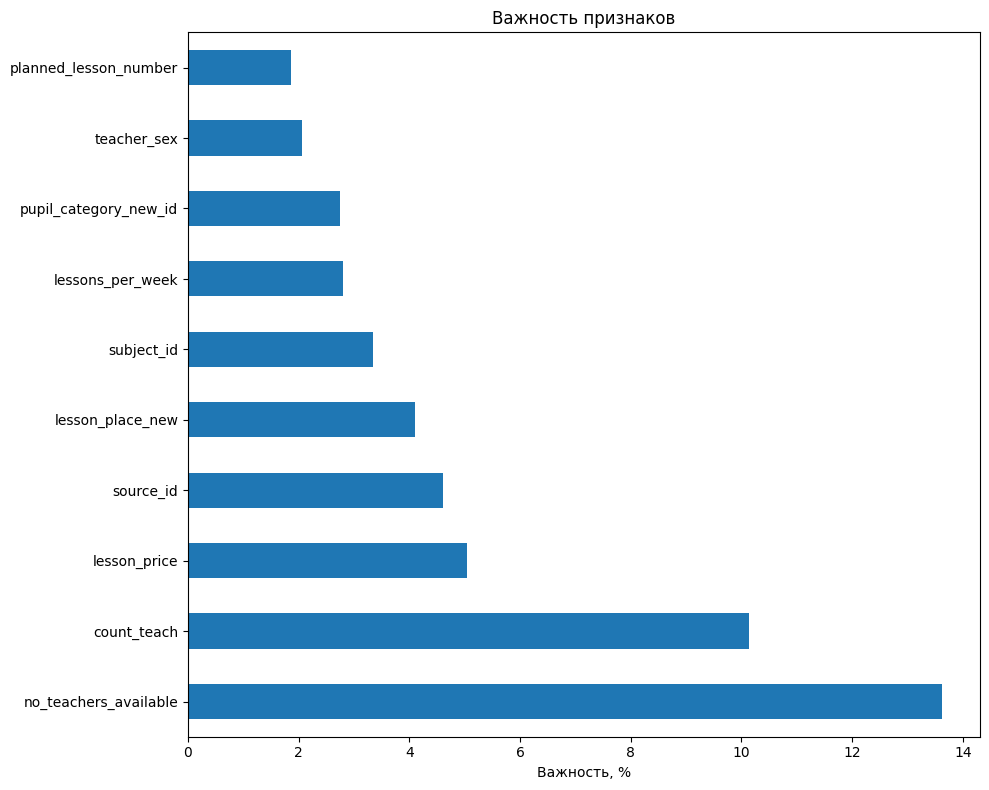

In [20]:
importances = model.feature_importances_
feat_imp_dict = dict(zip(train_X.columns, importances))
sorted_dict_feat_imp = sorted(feat_imp_dict.items(), key=lambda x: x[1], reverse=True)
cat_rep_imp = pd.Series(list([i[1] for i in sorted_dict_feat_imp][:10]),
                        list([i[0] for i in sorted_dict_feat_imp][:10]))
fig, ax = plt.subplots(figsize=(10,8))
cat_rep_imp.plot.barh(ax=ax)
ax.set_title("Важность признаков")
ax.set_xlabel('Важность, %')
fig.tight_layout()